In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_17198.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_13422.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_18487.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_15803.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_2331.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_9639.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_18638.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_15574.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_7512.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_8596.jpg
/kaggle/input/amazonsatelliteimages/test-jpg-additional/test-jpg-additional/file_13814.jpg
/ka

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing import image
import os
import random

2024-07-29 14:24:46.784733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:24:46.784801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:24:46.786408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load labels
labels_df = pd.read_csv('/kaggle/input/amazonsatelliteimages/train_v2.csv/train_v2.csv')

# Create binary labels for deforestation
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x or 'slash_burn' in x else 0)

# Add file extensions to image filenames
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: f"{x}.jpg")

# Split dataset into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [5]:

def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col='deforestation',
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

# Set the path to dataset directory
data_dir = '/kaggle/input/amazonsatelliteimages/train-jpg/train-jpg'

# Create dataset generators for training and validation sets
train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base_model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc'), Precision(), Recall()])

In [7]:
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3085s 3s/step - auc: 0.5058 - loss: 0.3457 - precision: 0.1203 - recall: 0.0065 - val_auc: 0.7181 - val_loss: 0.3109 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3074s 3s/step - auc: 0.5456 - loss: 0.3146 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.8147 - val_loss: 0.2986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3069s 3s/step - auc: 0.5989 - loss: 0.3095 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.8242 - val_loss: 0.2901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3082s 3s/step - auc: 0.6192 - loss: 0.3083 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.8274 - val_loss: 0.2948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 3085s 3s/step - auc: 0.6259 - loss: 0.3065 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


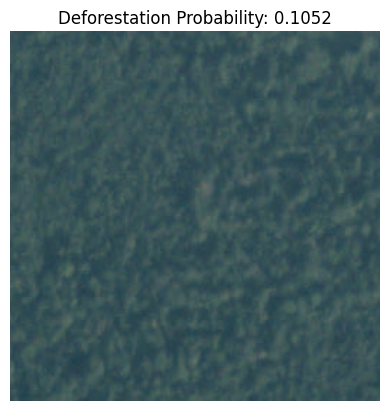

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


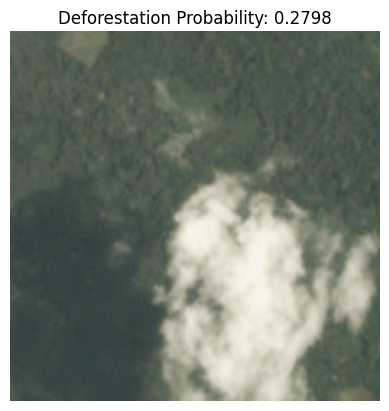

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


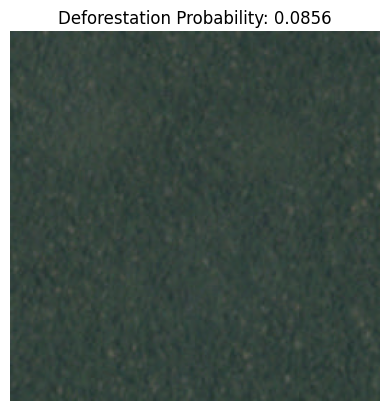

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


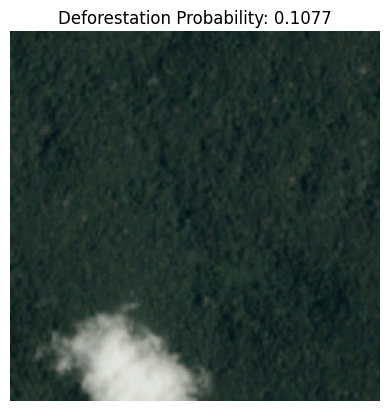

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


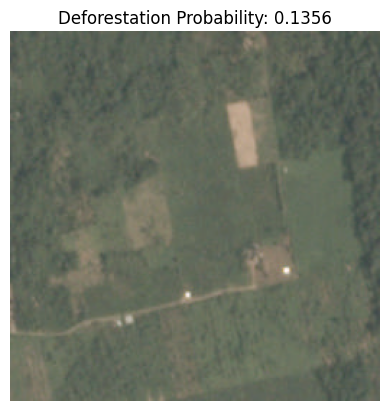

In [9]:
def predict_deforestation(model, img_path, img_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Make a prediction using the model
    preds = model.predict(x)

    return preds[0][0]

def display_image_with_prediction(img_path, deforestation_prob):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}")
    plt.axis("off")
    plt.show()

# Set path to the test dataset directory
test_data_dir = '/kaggle/input/amazonsatelliteimages/test-jpg/test-jpg'

# Choose a few random images from test dataset
test_images = random.sample(os.listdir(test_data_dir), 5)

# Evaluate model's performance on selected test images
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    deforestation_prob = predict_deforestation(model, img_path)
    display_image_with_prediction(img_path, deforestation_prob)


In [10]:
model.save('/kaggle/working/deforestation_model.h5')